# Working with time series, frequency series, and unit conversion

In this notebook, we show some of the most useful features of the [timeseries](../series.rst) module. To do so, we will analyze a fake gravitational-wave signal. We will also show the [frequencyseries](../series.rst) module and the [unitconv](../unitconv.rst) modules.

First, let's generate this signal. 

(This notebook is meant to be converted in Sphinx documentation and not used directly.)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from kuibit import timeseries as ts
from kuibit import series
from kuibit import unitconv as uc
from kuibit.gw_utils import luminosity_distance_to_redshift

%matplotlib inline

In [2]:
t = np.linspace(0, 20, 5000)
y = np.sin(t)

# Generate a TimeSeries by providing the times and the values of the series
gw = ts.TimeSeries(t, y)

To access the times and the values, use ``gw.t`` and ``gw.y``. You can also iterate over the series with a for loop yielding the elements `(t, y)` at each iteration of the loop. For example.

In [3]:
for tt, yy in gw:
    print(tt, yy)

0.0 0.0
0.004000800160032006 0.004000789486971321
0.008001600320064013 0.008001514935783532
0.012002400480096018 0.012002112309302542
0.016003200640128026 0.016002517572444287
0.020004000800160033 0.020002666693199687
0.024004800960192037 0.024002495643659576
0.028005601120224044 0.028001940401039562
0.03200640128025605 0.03200093694870479
0.03600720144028806 0.03599942127719461
0.040008001600320066 0.03999732938524717
0.04400880176035207 0.0439945972808238
0.048009601920384073 0.04799116098213332
0.05201040208041608 0.05198695651865616
0.05601120224044809 0.055981919932168285
0.060012002400480095 0.059975987277764924
0.0640128025605121 0.06396909462488413
0.0680136027205441 0.06796117805833003
0.07201440288057612 0.07195217367929596
0.07601520304060812 0.07594201760638712
0.08001600320064013 0.07993064597664322
0.08401680336067213 0.08391799494656059
0.08801760352070415 0.08790400069311417
0.09201840368073615 0.09188859941477902
0.09601920384076815 0.09587172733255157
0.10002000400080

0.39038021839729903
2.7445489097819564 0.38669375235790715
2.7485497099419884 0.3830010967511509
2.7525505101020205 0.37930231068308135
2.7565513102620525 0.3755974533578758
2.7605521104220845 0.3718865840768907
2.7645529105821165 0.3681697622377119
2.7685537107421485 0.3644470473332044
2.7725545109021805 0.3607184989505595
2.7765553110622125 0.35698417677034183
2.7805561112222446 0.3532441405655332
2.7845569113822766 0.34949845020057657
2.7885577115423086 0.3457471656304173
2.7925585117023406 0.34199034689954394
2.7965593118623726 0.3382280541410268
2.8005601120224046 0.3344603475755556
2.8045609121824366 0.3306872875104755
2.8085617123424687 0.3269089343388218
2.8125625125025007 0.3231253485383533
2.8165633126625327 0.31933659067058423
2.8205641128225647 0.3155427213798149
2.8245649129825967 0.3117438013921611
2.8285657131426287 0.3079398915145818
2.8325665133026607 0.3041310526339062
2.8365673134626928 0.300317345715859
2.8405681136227248 0.29649883180408443
2.844568913782757 0.2926

0.9950431157141746
7.957591518303661 0.9946372959000881
7.961592318463693 0.9942155555429143
7.965593118623725 0.9937779013931897
7.969593918783756 0.9933243404561733
7.973594718943788 0.992854879991734
7.97759551910382 0.9923695275142346
7.981596319263852 0.9918682907924117
7.985597119423884 0.9913511778492509
7.989597919583916 0.9908181969618587
7.993598719743948 0.9902693566613302
7.99759951990398 0.9897046657326121
8.001600320064012 0.9891241332143622
8.005601120224044 0.9885277683988051
8.009601920384076 0.9879155808315828
8.013602720544108 0.9872875803116026
8.01760352070414 0.9866437768908798
8.021604320864173 0.9859841808743769
8.025605121024205 0.9853088028198388
8.029605921184237 0.9846176535376236
8.033606721344269 0.98391074409053
8.0376075215043 0.9831880857936194
8.041608321664333 0.9824496902140356
8.045609121824365 0.9816955691708192
8.049609921984397 0.9809257347347187
8.053610722144429 0.9801401992279969
8.05761152230446 0.9793389752242343
8.061612322464493 0.97852207

-0.9911151607871486
10.86617323464693 -0.9916393598464145
10.870174034806961 -0.9921476863486984
10.874174834966993 -0.9926401321575329
10.878175635127025 -0.9931166893906429
10.882176435287057 -0.9935773504200719
10.88617723544709 -0.9940221078723043
10.890178035607121 -0.994450954628383
10.894178835767153 -0.9948638838240236
10.898179635927185 -0.9952608888497242
10.902180436087217 -0.9956419633508714
10.90618123624725 -0.9960071012278416
10.910182036407281 -0.996356296636099
10.914182836567313 -0.996689543986289
10.918183636727345 -0.9970068379443278
10.922184436887378 -0.9973081734314873
10.92618523704741 -0.9975935456244772
10.930186037207442 -0.9978629499555216
10.934186837367474 -0.9981163821124321
10.938187637527506 -0.9983538380386774
10.942188437687538 -0.9985753139334473
10.94618923784757 -0.9987808062517145
10.950190038007602 -0.9989703117042907
10.954190838167634 -0.9991438272578795
10.958191638327666 -0.999301350135125
10.962192438487698 -0.999442877814656
10.966193238647


13.982796559311863 0.9881085354482563
13.986797359471895 0.9887157808124926
13.990798159631927 0.9893072004156654
13.994798959791959 0.9898827847912878
13.998799759951991 0.9904425247263369
14.002800560112023 0.9909864112614024
14.006801360272055 0.9915144356908295
14.010802160432087 0.9920265895628582
14.01480296059212 0.9925228646797586
14.018803760752151 0.9930032530979624
14.022804560912183 0.9934677471281897
14.026805361072215 0.9939163393355724
14.030806161232247 0.994349022539773
14.03480696139228 0.9947657898150991
14.038807761552311 0.9951666344906154
14.042808561712343 0.9955515501502492
14.046809361872375 0.9959205306328942
14.050810162032407 0.9962735700325084
14.05481096219244 0.9966106626982086
14.058811762352471 0.9969318032343615
14.062812562512503 0.9972369865006693
14.066813362672535 0.9975262076122526
14.070814162832567 0.9977994619397282
14.0748149629926 0.9980567451092834
14.078815763152631 0.9982980530027458
14.082816563312663 0.9985233817576493
14.08681736347269

16.543308661732347 -0.7415282881048536
16.54730946189238 -0.7442065696104206
16.55131026205241 -0.7468729390624116
16.555311062212443 -0.7495273537819025
16.559311862372475 -0.7521697712813211
16.563312662532507 -0.7548001492651272
16.56731346269254 -0.7574184456304897
16.57131426285257 -0.7600246184679607
16.575315063012603 -0.7626186260621458
16.579315863172635 -0.7652004268923723
16.583316663332667 -0.7677699796333536
16.5873174634927 -0.7703272431558505
16.59131826365273 -0.77287217652733
16.595319063812763 -0.7754047390126199
16.599319863972795 -0.7779248900745612
16.603320664132827 -0.7804325893746572
16.60732146429286 -0.7829277967737183
16.61132226445289 -0.7854104723325052
16.615323064612923 -0.7878805763123683
16.619323864772955 -0.7903380691758831
16.623324664932987 -0.7927829115874836
16.62732546509302 -0.7952150644140917
16.63132626525305 -0.7976344887257438
16.635327065413083 -0.8000411457962135
16.639327865573115 -0.8024349971036319
16.643328665733147 -0.8048160043311037

19.007801560312064 0.1575860090613892
19.011802360472096 0.1615355485558386
19.015803160632128 0.16548250245082222
19.01980396079216 0.16942680756989392
19.023804760952192 0.17336840077900487
19.027805561112224 0.17730721898751411
19.031806361272256 0.18124319914919843
19.035807161432288 0.1851762782632614
19.03980796159232 0.18910639337534196
19.043808761752352 0.1930334815785219
19.047809561912384 0.19695748001433291
19.051810362072416 0.20087832587376267
19.055811162232448 0.20479595639826023
19.05981196239248 0.20871030888074046
19.063812762552512 0.21262132066658782
19.067813562712544 0.21652892915465927
19.071814362872576 0.22043307179828625
19.07581516303261 0.22433368610627577
19.07981596319264 0.2282307096439108
19.083816763352672 0.23212408003394946
19.087817563512704 0.2360137349576236
19.091818363672736 0.23989961215563627
19.09581916383277 0.24378164942915811
19.0998199639928 0.2476597846408232
19.103820764152832 0.2515339557157234
19.107821564312864 0.25540410064240215
19

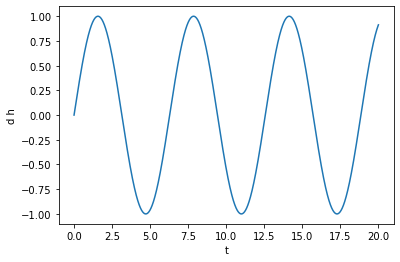

In [4]:
def plot(ser, lab1="d h", lab2="t", *args, **kwargs):
    """Plot Series ser with labels"""
    plt.ylabel(lab1)
    plt.xlabel(lab2)
    plt.plot(ser, *args, **kwargs)
    
plot(gw)

Let's make this more interesting: we square the signal and add Gaussian noise. [TimeSeries](../timeseries_ref.html#kuibit.timeseries.TimeSeries) support directly using all the basic mathematical operations in Python and NumPy, so we can easily square the signal and add another TimeSeries to it.

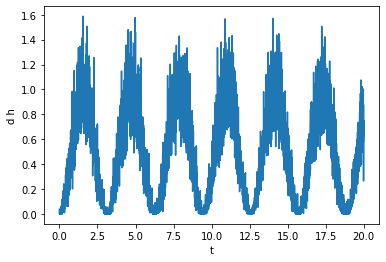

In [5]:
noise = np.random.normal(0, 0.1, len(gw))  # Here we used len() on the TimeSeries
noise_ts = ts.TimeSeries(t, noise)

gw += noise_ts
gw **= 2

plot(gw)

To analyze this signal, first we will smooth it. To do that, we will use the [savgol_smooth_time](../timeseries_ref.html#kuibit.timeseries.TimeSeries.savgol_smooth_time) method, which is a generalized "running average" filter. This method requires length of time over which we want to smooth the data.

In [TimeSeries](../timeseries_ref.html#kuibit.timeseries.TimeSeries) there are always two different methods to do the same task, one with imperative verb (e.g., smooth), and the other with the past tense (e.g., smoothed). The first modifies the data, the second returns a new `TimeSeries` with the operation applied. Here, we will find what smoothing length to use by trial and error, so we will use the second method. 

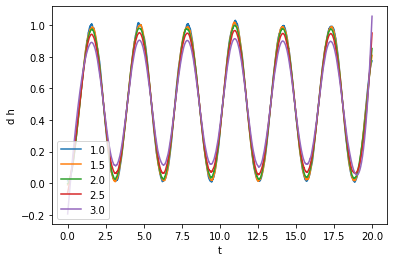

In [6]:
tsmooth = np.linspace(1, 3, 5)

for tsm in tsmooth:
    smoothed = gw.savgol_smoothed_time(tsm)
    plot(smoothed, label=tsm)
plt.legend()

From visual inspection it looks like that ``tsmooth = 1.5`` will work yield a clean series faithful to the original one.

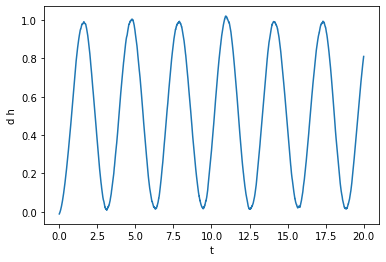

In [7]:
gw.savgol_smooth_time(1.5)
plot(gw)

Next, for fun, we can compute integrals and derivatives. For instance, we can compute what is the integral from 5 to 10.

The integral from 5 to 10 is 2.1961


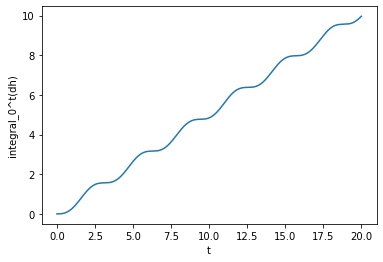

In [8]:
gw_int = gw.integrated()
a = 5
b = 10
print(f"The integral from {a} to {b} is {gw_int(b) - gw_int(a):.4f}")
plot(gw_int, lab1="integral_0^t(dh)")

Here, we showed a very powerful feature of `TimeSeries`: you can call them on a specific time (as we did we ``gw_int(b)``). This is done using splines to interpolate to the points that are not available. Splines can also be used to take derivatives. Alternatively, one can simply take the finite (central) difference. Let's see what's the derivative of ``gw`` using splines and finite difference.

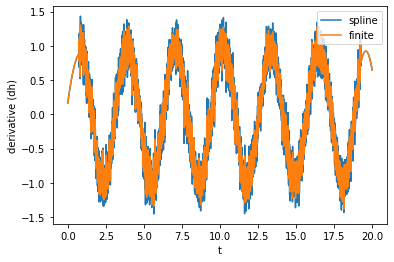

In [9]:
gw_spline_der = gw.spline_differentiated()
gw_numer_der = gw.differentiated()

plot(gw_spline_der, label='spline')
plot(gw_numer_der, lab1="derivative (dh)", label='finite')
plt.legend()

Clearly, derivatives will be noisier than the actual data, so often it is convenient to smooth them out as shown before.

TimeSeries support complex signals. Now, we will create one using `gw` itself. We will copy `gw`, time-shift it, find the common time interval with the original `gw`, and use that as a the imaginary part.

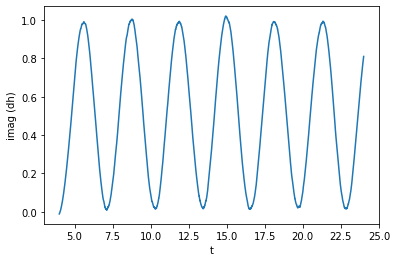

In [10]:
gw_imag = gw.copy()  # It is important to deep copy the object
gw_imag.time_shift(4)

plot(gw_imag, lab1 ="imag (dh)")

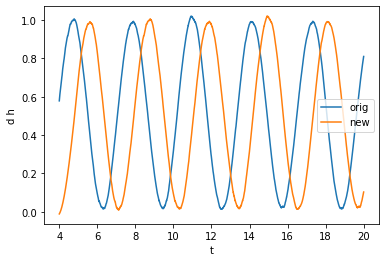

In [11]:
gw, gw_imag = series.sample_common([gw, gw_imag], resample=True)  # Resampling to common times

plot(gw, label="orig")
plot(gw_imag, label="new")
plt.legend()

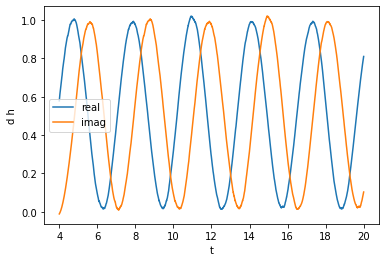

In [12]:
gw_complex = ts.TimeSeries(gw.t, gw.y + 1j * gw_imag.y)

plot(gw_complex.real(), label="real")
plot(gw_complex.imag(), label="imag")
plt.legend()

We can also compute the phase and absolute value. In particular, we will compute the unfolded phase (no wrapping over $2\pi$)

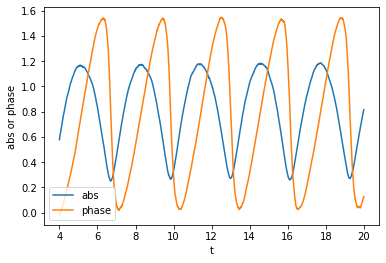

In [13]:
plot(gw_complex.abs(), label='abs')
plot(gw_complex.unfolded_phase(), lab1="abs or phase", label='phase')
plt.legend()

Here, the unfolded phase looks a little bit unusual. This is because we made up the signal.

We can also compute the frequency of the phase, which we can directly smooth.

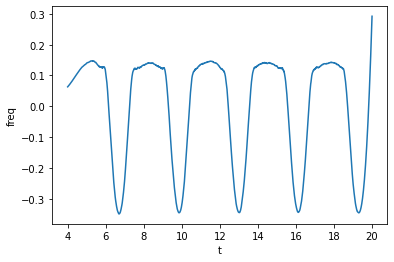

In [14]:
plot(gw_complex.phase_frequency(tsmooth=1.5), lab1="freq")

Next, we will take a Fourier transform. Before, let's pretend that the signal was in geometrized units (as in simulations), and let's make it physical assuming a scale of $M = 1 M_\odot$. For that, use the [unitconv](../unitconv.rst) module. We define a CU object that knows how to convert units.

In [15]:
CU = uc.geom_umass_msun(1) 

# How to convert from geometrized length to physical length?
# Simply multiply times CU.length. Let's check that it is 1.477 km
CU.length  # m

1476.6436994724972

Now we rescale `gw`, assuming that `y` is strain times distance (as usually is). Let's assume a distance of 500 Mpc.

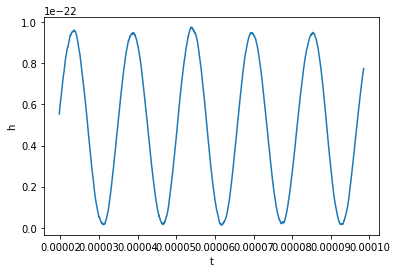

In [16]:
d_Mpc = 500

# inverse = True means from geometrized to physical
gw_physical = gw_complex.time_unit_changed(CU.time, inverse=True)  

gw_physical *= CU.length  # dh -> dh physical
# Now just the strain, since we assume a distance
gw_physical /= (d_Mpc * uc.MEGAPARSEC_SI)

# We have to manually add the redshift
gw_physical.redshifted(luminosity_distance_to_redshift(d_Mpc))

plot(gw_physical.real(), lab1="h")

Okay, now before taking the Fourier transform, we will remove the mean and window our signal. A Tukey window will work.

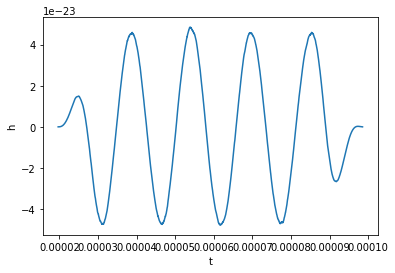

In [17]:
gw_physical.mean_remove()
gw_physical.tukey_window(0.3)
plot(gw_physical.real(), lab1="h")

Finally, we can take the Fourier transform. This is easy to do:

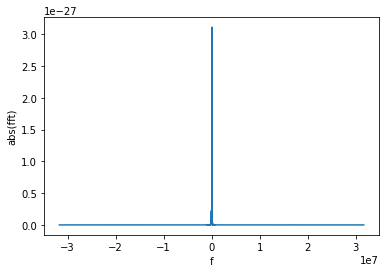

In [18]:
gw_fft = gw_physical.to_FrequencySeries()

# Plotting the amplitude of the Fourier transform
plot(gw_fft.abs(), lab1="abs(fft)", lab2="f")

The new object is a `FrequencySeries`. It is very similar to a `TimeSeries` and it shares several properties, methods, and features. 

Let's restrict to only positive frequencies close to zero.

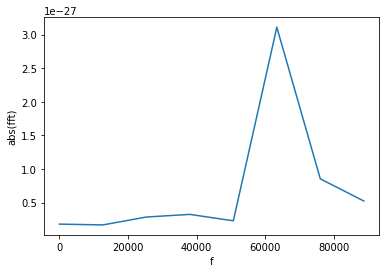

In [19]:
gw_fft.crop(0, 1e5)
plot(gw_fft.abs(), lab1="abs(fft)", lab2="f")

We can find the frequency of that peak! For this, we find all the peaks with amplitude larger than 1e-27.

Frequency: 64203.34


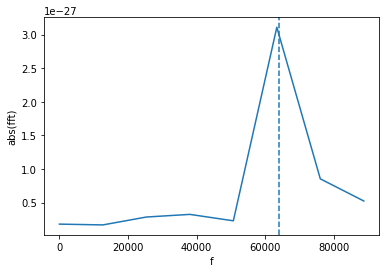

In [20]:
f_peak = gw_fft.peaks_frequencies(1e-27)[0]

print(f"Frequency: {f_peak:.2f}")
plot(gw_fft.abs(), lab1="abs(fft)", lab2="f")
plt.axvline(f_peak, ls = 'dashed')

The line is not on the maximum because we use a quadratic interpolation to find a more accurate location of the peak.

Sometimes, it is useful to ignore some data (or example, when we know that the data is invalid). `Series` objects support _masks_ to mark the points we want to ignore. Most functions work transparently with masks: for example, if you ask for the mean of a `Series`, the masked point will be ignored. Other functions do not support masks (most notably, splines). In that case, it is best to completely remove the masked points and work with clean data.

In [21]:
# Let's mask all the point in the spectrum with value larger than 1e-27

spectrum = gw_fft.abs()

print(f"Maximum without mask {spectrum.max():.3e}")

# Apply mask
spectrum.mask_greater(1e-27)

print(f"Maximum with mask {spectrum.max():.3e}")

print(f"Length with mask {len(spectrum)}")

# Remove points
spectrum.mask_remove()

print(f"Length after having removed the masked points {len(spectrum)}")

Maximum without mask 3.109e-27
Maximum with mask 8.530e-28
Length with mask 8
Length after having removed the masked points 7
